## Changing mutation rate and adding mutational biases

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

fdir = '../data/'
out_fdir = '../plots/fig4/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### 1.1 Changing mutation rate

As before, we specify the required parameters including the number of non-specific binding sites (`n_NS`), copy number of RNAP (`n_p`), copy number of the repressor (`n_r`), binding energy of the RNAP at the wild-type binding site (`ep_wt`) and binding energy of the repressor at the wild-type binding site (`er_wt`).

In [6]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -15

We simulate synthetic datasets for a range of mutation rates from 0.03 to 0.26. At each mutation rate, we simulate 20 synthetic datasets and we keep track of the average mutual information at the RNAP and repressor binding sites.

In [7]:
mutrate = np.arange(0.03, 0.26, 0.01)
signal_rnap = []
signal_rep = []

for mr in mutrate:
    rnap = []
    rep = []
    for i in range(20):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                mutrate=float(mr))

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)
        nbins = 2

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        rep.append(np.mean(footprint[(2+115):(17+116)]))
    signal_rnap.append((np.mean(rnap), np.std(rnap)))
    signal_rep.append((np.mean(rep), np.std(rep)))

The average mutual information at the RNAP binding site and at the repressor binding site are plotted against the mutation rate.

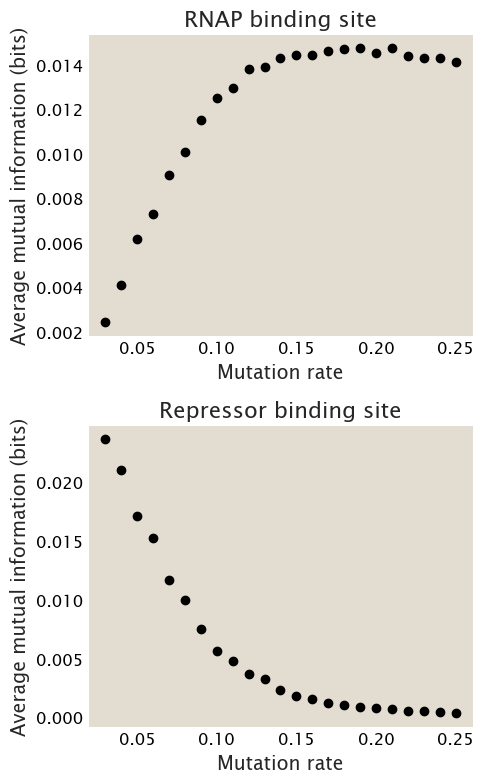

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(5, 8))
ax1, ax2 = axes
ax1.scatter(mutrate, np.asarray(signal_rnap)[:, 0], color='k')
ax1.set_xlabel('Mutation rate', fontsize=14)
ax1.set_ylabel('Average mutual information (bits)', fontsize=14)
ax1.set_title('RNAP binding site', fontsize=16)

ax2.scatter(mutrate, np.asarray(signal_rep)[:, 0], color='k')
ax2.set_xlabel('Mutation rate', fontsize=14)
ax2.set_ylabel('Average mutual information (bits)', fontsize=14)
ax2.set_title('Repressor binding site', fontsize=16)

plt.tight_layout()
plt.savefig(out_fdir + 'mutation_rate.pdf', dpi=300)

### 1.2 Example footprints with different mutation rates

Let us plot some representative information footprints at some of the mutation rates. Below is an information footprint at a low mutation rate of 0.04.

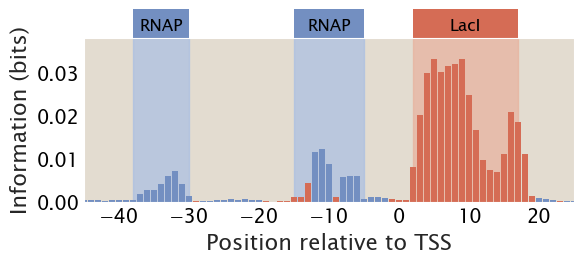

In [9]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        mutrate=0.04)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile=out_fdir + 'mutation_rate_fp1.pdf')

Below is an information footprint at a mutation rate of 0.1, which is the typical mutation rate used in Reg-Seq.

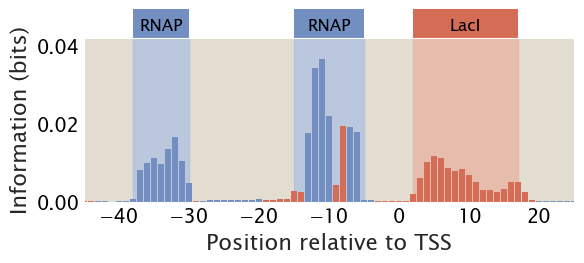

In [10]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        mutrate=0.1)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile=out_fdir + 'mutation_rate_fp2.pdf')

Below is an information footprint at a high mutation rate of 0.2

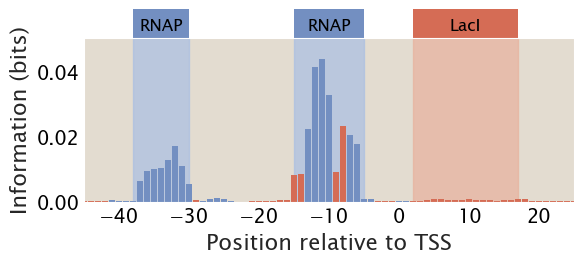

In [11]:
df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        mutrate=0.2)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile=out_fdir + 'mutation_rate_fp3.pdf')

### 2. Mutational bias

Finally, let us add mutational biases to the library and take a look at the effects on the mutational biases on the information footprints. We first specify the typical parameter values as before.

In [12]:
n_NS = len(genome)
n_p = 5000
n_r = 15
ep_wt = -5
er_wt = -15

In the `sim` function, we can specify an optional argument called `allowed_alph`, which takes in a 4 by 4 array where each row is a base identity and each column is a base identity that it can be mutated into. The boolean value stored in the element specifies whether a given mutation is allowed.

Below, we specify an `allowed_alph` where only swappings between A and G and swappings between C and T are allowed. 

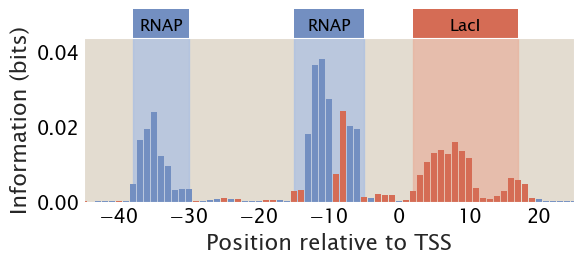

In [13]:
allowed_alph = np.array([[False, False, True, False],
                         [False, False, False, True],
                         [True, False, False, False],
                         [False, True, False, False]])

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        allowed_alph=allowed_alph)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile=out_fdir + 'mutation_bias_fp1.pdf')

In comparison, we specify an `allowed_alph` where only mutations from C to T and from G to A are allowed. Note that here we also do not smooth the final footprint in order to see the full effects of the mutational bias on the information footprints.

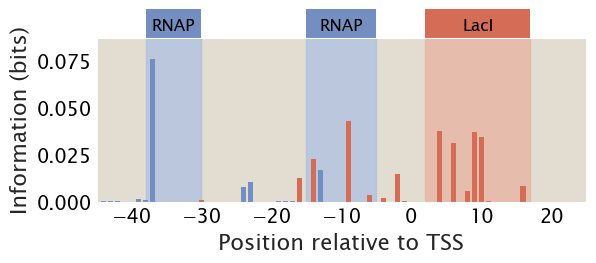

In [14]:
allowed_alph = np.array([[False, False, False, False],
                         [False, False, False, True],
                         [True, False, False, False],
                         [False, False, False, False]])

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        allowed_alph=allowed_alph, mutrate=0.1,
                        biased=True)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=6,
                               outfile='../plots/fig4/mutation_bias_fp2.pdf', smoothed=False)